# Modelling using value of R0

Modelling with R0 as target variable. R0 represents the average number of people infected by one infectious individual. 

## Import libraries

In [6034]:
import pandas as pd, numpy as np, time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV

# Librerías para plots
from sklearn import tree
#import graphviz
from scipy.stats import norm
from scipy.stats import t
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

## Read file and prepare data 

In [6035]:
#df = pd.read_csv('/Users/lucas_botella/Downloads/df_covid_processed.csv')
#df = pd.read_csv('/Users/lucas_botella/Downloads/cluster_covid_data.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/raw_deaths_covid_data.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/cluster_per_deaths_for_model.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/raw_deaths_covid_data.csv')
df=pd.read_csv('/Users/lucas_botella/Downloads/df_covid_processed_FINAL.csv')
del df['Unnamed: 0']
del df['deaths_prev_18']
del df['Excess mortality P-scores, all ages']
del df['Excess mortality P-scores, all ages Prev 18 days']
del df['average_deaths_2015_2019_all_ages']
del df['deaths']
del df['month']
del df['life_expectancy']
del df['%df_population_gr_65']
del df['UN Population Division (Median Age) (2017)']
del df['number_of_arrivals']
del df['doctors_per_1000']
del df['nurses_per_1000']
del df['beds_per_1000']
del df['%youth_unemployment_total']

In [6036]:
df.columns

Index(['Code', 'Date', 'retail_and_recreation', 'grocery_and_pharmacy',
       'residential', 'transit_stations', 'parks', 'workplaces',
       'contact_tracing', 'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'debt_relief', 'income_support', 'Holiday', 'temp', 'prcp',
       'urban_population', 'total_vaccinations_per_100', 'accumulated', 'R0'],
      dtype='object')

In [6037]:
df

,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,contact_tracing,testing_policy,...,school_closures,debt_relief,income_support,Holiday,temp,prcp,urban_population,total_vaccinations_per_100,accumulated,R0
0,AUS,2020-03-08,1.05,1.72,-0.74,4.98,-2.09,7.93,2.00,1.00,...,0.00,0.00,0.00,0.00,23.57,0.11,85.90,nan,0.00,0.99
1,AUS,2020-03-15,0.76,1.51,-1.29,7.70,-0.82,10.57,2.00,1.00,...,0.00,0.00,0.00,0.00,22.45,0.13,85.90,nan,0.00,1.00
2,AUS,2020-03-22,1.29,3.37,-1.08,9.35,0.94,10.88,2.00,1.00,...,0.00,0.00,0.00,0.00,21.81,0.16,85.90,nan,0.00,1.02
3,AUS,2020-03-29,0.71,8.98,-0.39,5.45,-2.86,8.33,2.00,1.00,...,0.00,0.00,0.00,0.00,21.35,0.14,85.90,nan,0.00,1.07
4,AUS,2020-04-05,-0.90,15.16,0.45,-1.06,-4.96,6.96,2.00,1.00,...,0.00,0.00,1.00,0.00,21.18,0.05,85.90,nan,0.00,1.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,USA,2021-01-10,-17.69,-4.06,10.18,-36.04,-19.76,-28.10,1.00,3.00,...,3.00,1.00,2.00,0.00,2.89,0.05,82.06,nan,0.18,0.97
2038,USA,2021-01-17,-22.78,-3.98,12.65,-38.88,-16.65,-42.08,1.00,3.00,...,3.00,1.00,2.00,1.00,1.71,0.07,82.06,nan,0.19,0.95
2039,USA,2021-01-24,-23.63,-9.84,14.06,-41.02,-15.86,-41.71,1.00,3.00,...,3.00,1.00,2.00,1.00,2.50,0.09,82.06,0.17,0.20,0.89
2040,USA,2021-01-31,-23.98,-11.39,11.45,-39.57,-22.59,-29.00,1.00,3.00,...,3.00,1.00,2.00,0.00,1.20,0.04,82.06,0.51,0.21,0.91


## Feature Engineering

df['nurses_per_1000']=df.apply(lambda x: x['nurses_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['nurses_per_1000'] - (x['nurses_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)
df['doctors_per_1000']=df.apply(lambda x: x['doctors_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['doctors_per_1000'] - (x['doctors_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)
df['beds_per_1000']=df.apply(lambda x: x['beds_per_1000'] if x['Excess mortality P-scores, all ages Prev 18 days'] <= 0 else 
         x['beds_per_1000'] - (x['beds_per_1000']*x['Excess mortality P-scores, all ages Prev 18 days']), axis=1)
df['health_power']=-((df['nurses_per_1000']+df['doctors_per_1000']+df['beds_per_1000'])/3)

del df['nurses_per_1000']
del df['doctors_per_1000']
del df['beds_per_1000']

Text(0.5, 1.0, 'R0')

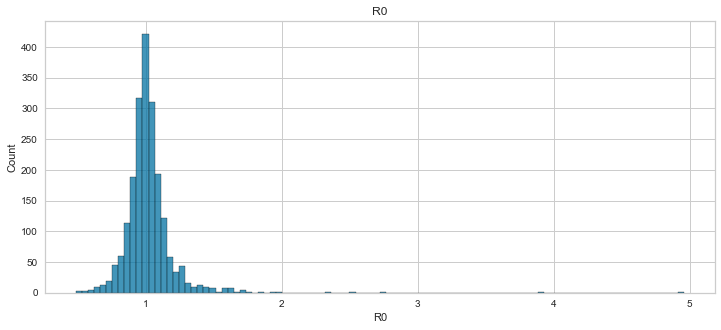

In [6038]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='R0', data=df, kde=False, bins=100, ax=axes);
axes.set_title('R0')

In [6039]:
df['R0'].describe()

count   2042.00
mean       1.02
std        0.19
min        0.48
25%        0.94
50%        1.00
75%        1.07
max        4.96
Name: R0, dtype: float64

In [6042]:
X=df[df.columns[2:-1]]
y=df['R0']

# Modelling and Results

pip install xgboost

In [6043]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import fbeta_score, make_scorer
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Predictions from January 2021
date1=pd.Timestamp(2021, 1, 1)

X_1=df[(pd.to_datetime(df['Date']) <= date1)]
X_2=df[(pd.to_datetime(df['Date']) > date1)]
X_train=X_1[X_1.columns[2:-1]]
X_test=X_2[X_2.columns[2:-1]]
y_train=X_1['R0']
y_test=X_2['R0']

## XGBoost Regressor 

### GridSearchCV 

In [6045]:
#Mape custom scoring function
def mape_fun(pred, train): 
    return np.mean(np.abs((pred - train) / train)) * 100

In [6046]:
from sklearn.model_selection import StratifiedKFold
# A parameter grid for XGBoost
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,5)],  'subsample':[i/10.0 for i in range(8,11)],
'colsample_bytree':[i/10.0 for i in range(8,11)], 'max_depth': [6,7,8]}

# Initialize XGB and GridSearch
xgb = XGBRegressor(num_boost_rounds=1000) 

grid = GridSearchCV(xgb, params, verbose=1, n_jobs=-1, scoring=make_scorer(mape_fun))

In [6049]:
%%time
grid.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  2.3min finished


[18:00:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CPU times: user 4 s, sys: 192 ms, total: 4.19 s
Wall time: 2min 16s


In [6050]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0.4, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=7,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_boost_rounds=1000,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
y_pred=grid.best_estimator_.predict(X_test)
y_pred_train=grid.best_estimator_.predict(X_train)

### XGB Evaluation

### Test Set

In [6053]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.11594152287734692
mse score is 0.02454195871483508
rmse score is 0.15665873328619467
r2 score is -0.22820802167177923
mape score is 12.673331522368034


### Train Set

In [6055]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape': mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.07476271549962285
mse score is 0.012241320219462776
rmse score is 0.1106404999060596
r2 score is 0.6860977799885075
mape score is 7.166409387289005


In [6056]:
#Actual vs Predcited Dataframe
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval['Difference']=np.abs(df_eval['Actual']-df_eval['Predicted'])
df_eval

,Actual,Predicted,Difference
47,0.91,1.20,0.29
48,1.05,1.24,0.18
49,1.09,1.28,0.19
89,0.75,0.96,0.21
90,0.79,0.98,0.19
...,...,...,...
2037,0.97,0.91,0.06
2038,0.95,0.87,0.08
2039,0.89,0.87,0.03
2040,0.91,0.91,0.00


## Results View

### Predicted vs Actual R0 Distribution

Text(0.5, 1.0, 'R0_Predicted')

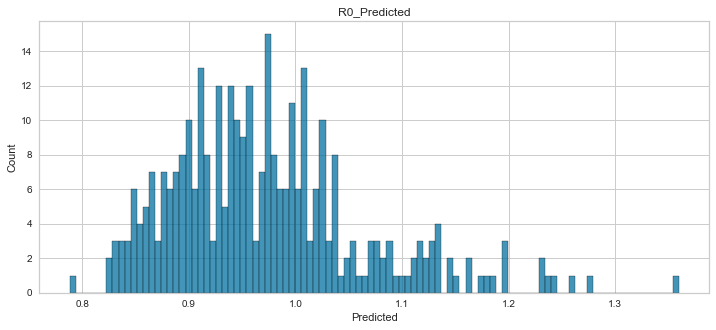

In [6057]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Predicted', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Predicted')

Text(0.5, 1.0, 'R0_Actual')

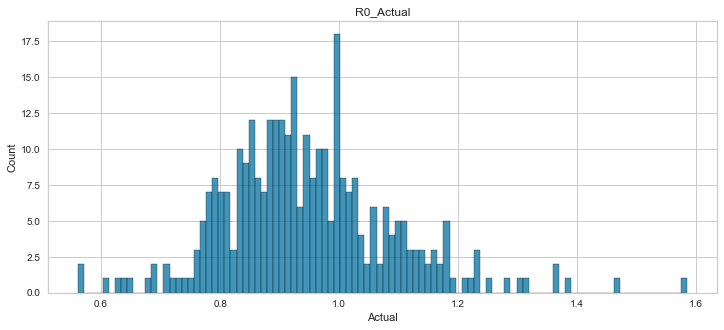

In [6058]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Actual', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Actual')

## Model Evaluation Plots

### Difference Histogram 

In [ ]:
# plot difference hist
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Difference', data=df_eval, kde=False, bins=50, ax=axes);
axes.set_title('Difference Histogram')

### Actual vs Predicted

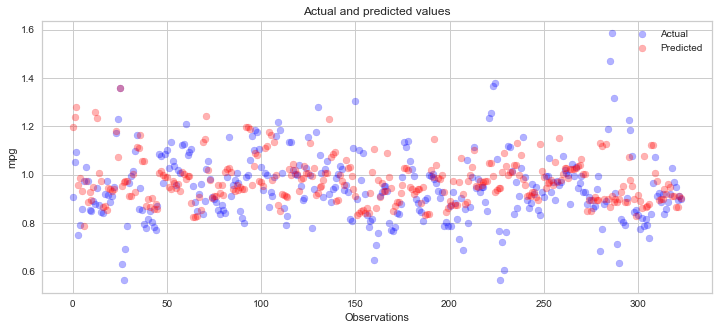

In [6060]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(12,5))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

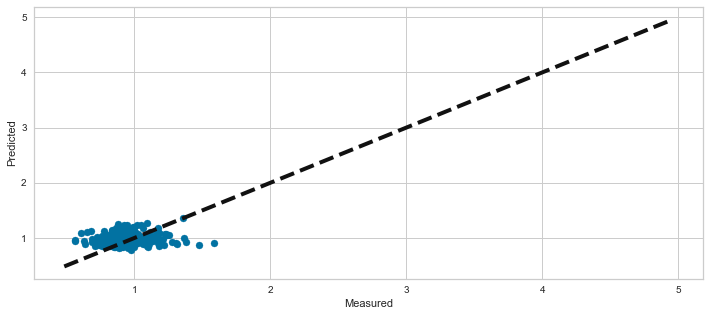

In [6061]:
fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(y_test, y_pred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

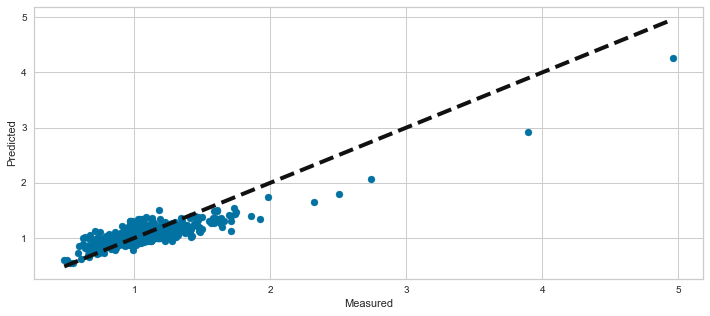

In [6062]:
fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(y_train, y_pred_train)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

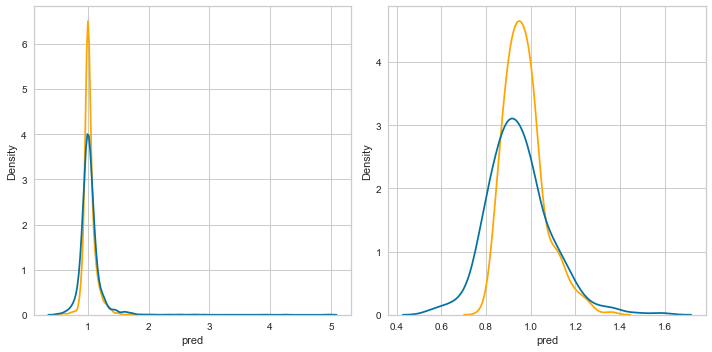

In [6063]:
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = y_pred
y_train_pred = y_pred_train

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0], color='orange')
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1], color='orange')
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

In [6065]:
res_df_test.sort_values('dif%')

,pred,test,dif,dif_abs,dif%
1746,0.91,1.58,-0.67,0.67,-42.36
1745,0.86,1.47,-0.61,0.61,-41.31
1426,0.93,1.38,-0.45,0.45,-32.65
1747,0.89,1.31,-0.43,0.43,-32.46
879,0.91,1.30,-0.39,0.39,-30.04
...,...,...,...,...,...
1701,1.13,0.68,0.45,0.45,65.92
1429,0.94,0.56,0.38,0.38,68.00
1018,1.10,0.65,0.46,0.46,70.38
199,0.97,0.56,0.41,0.41,72.55


## Feature importance 

In [6070]:
import xgboost
from xgboost import plot_importance
from xgboost import plot_tree

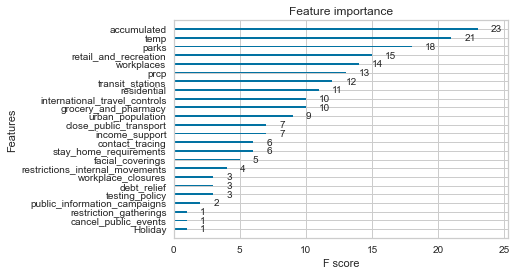

In [6071]:
xgboost.plot_importance(grid.best_estimator_)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

## Light GBM

In [5927]:
import lightgbm as lgb

In [5928]:
params = {
    'metric': ['regression_l1'],
    "max_depth":[4,5,6] ,
    "num_leaves": [50,60,70],  
    "max_bin": [200,400],
}

# Initialize LGB and GridSearch
lgbm = lgb.LGBMRegressor()

grid = GridSearchCV(lgbm, params)

In [5929]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'max_bin': [200, 400], 'max_depth': [4, 5, 6],
                         'metric': ['regression_l1'],
                         'num_leaves': [50, 60, 70]})

In [5930]:
grid.best_estimator_

LGBMRegressor(max_bin=200, max_depth=4, metric='regression_l1', num_leaves=50)

In [5789]:
def mape(y, y_pred):
    return np.mean(np.abs((y - y_pred) / y)) * 100

In [5931]:
y_pred = grid.best_estimator_.predict(X_test, num_iteration=gbm.best_iteration_)

In [5933]:
mape(y_pred, y_test)

TypeError: 'float' object is not callable

In [5935]:
y_pred_train = grid.best_estimator_.predict(X_train, num_iteration=gbm.best_iteration_)

In [5936]:
mape(y_pred_train, y_train)

TypeError: 'float' object is not callable

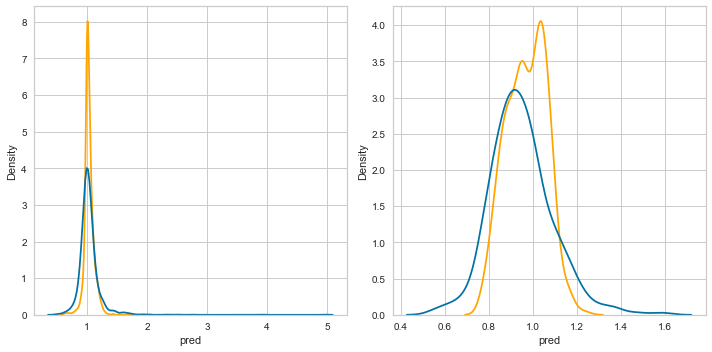

In [5937]:
import seaborn as sns
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = y_pred
y_train_pred = y_pred_train

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0], color='orange')
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1], color='orange')
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

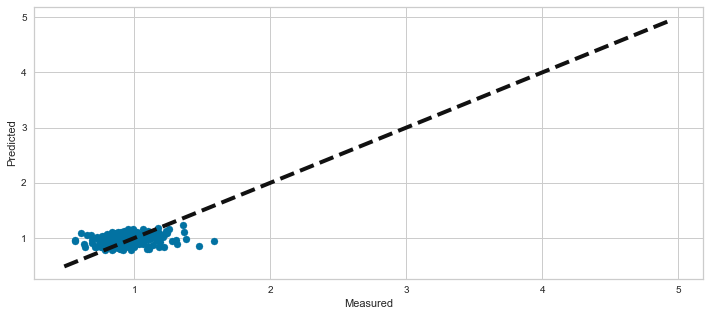

In [5938]:
fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(y_test, y_pred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

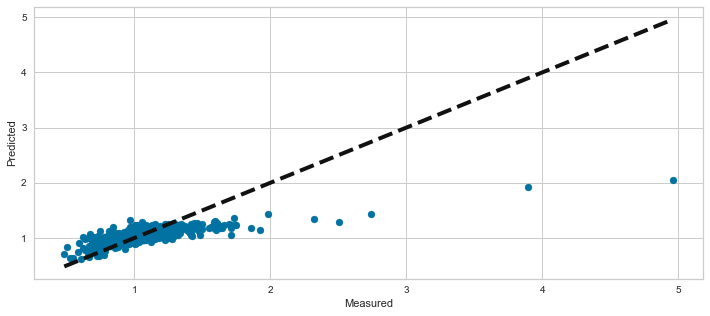

In [5939]:
fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(y_train, y_pred_train)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [6073]:
y_train

0      0.99
1      1.00
2      1.02
3      1.07
4      1.06
       ... 
2031   1.06
2032   1.08
2033   1.08
2034   1.07
2035   1.04
Name: R0, Length: 1718, dtype: float64

# CatBoost Regressor 

In [6104]:
# Now Catboost model training
from catboost import CatBoostRegressor
ctbst = CatBoostRegressor()

ctbst.fit(X_train, y_train)
ctbst.best_estimator_

Learning rate set to 0.042977
0:	learn: 0.1964448	total: 7.94ms	remaining: 7.93s
1:	learn: 0.1953319	total: 12.6ms	remaining: 6.31s
2:	learn: 0.1938315	total: 17.6ms	remaining: 5.83s
3:	learn: 0.1928320	total: 25.4ms	remaining: 6.33s
4:	learn: 0.1917519	total: 30.1ms	remaining: 5.99s
5:	learn: 0.1909100	total: 38ms	remaining: 6.29s
6:	learn: 0.1902661	total: 42.5ms	remaining: 6.03s
7:	learn: 0.1896702	total: 48.4ms	remaining: 6s
8:	learn: 0.1889888	total: 53.1ms	remaining: 5.85s
9:	learn: 0.1880587	total: 57.8ms	remaining: 5.72s
10:	learn: 0.1870531	total: 63.1ms	remaining: 5.67s
11:	learn: 0.1864385	total: 78.2ms	remaining: 6.44s
12:	learn: 0.1855208	total: 86.5ms	remaining: 6.57s
13:	learn: 0.1848079	total: 92.1ms	remaining: 6.49s
14:	learn: 0.1838305	total: 96.9ms	remaining: 6.36s
15:	learn: 0.1832188	total: 102ms	remaining: 6.26s
16:	learn: 0.1824912	total: 106ms	remaining: 6.1s
17:	learn: 0.1815310	total: 110ms	remaining: 6.02s
18:	learn: 0.1807555	total: 115ms	remaining: 5.91s
19

198:	learn: 0.1159906	total: 735ms	remaining: 2.96s
199:	learn: 0.1157743	total: 740ms	remaining: 2.96s
200:	learn: 0.1155764	total: 745ms	remaining: 2.96s
201:	learn: 0.1154046	total: 749ms	remaining: 2.96s
202:	learn: 0.1151485	total: 754ms	remaining: 2.96s
203:	learn: 0.1149153	total: 759ms	remaining: 2.96s
204:	learn: 0.1147513	total: 764ms	remaining: 2.96s
205:	learn: 0.1146499	total: 769ms	remaining: 2.96s
206:	learn: 0.1143982	total: 773ms	remaining: 2.96s
207:	learn: 0.1141961	total: 775ms	remaining: 2.95s
208:	learn: 0.1139865	total: 780ms	remaining: 2.95s
209:	learn: 0.1138402	total: 783ms	remaining: 2.94s
210:	learn: 0.1136018	total: 785ms	remaining: 2.94s
211:	learn: 0.1134535	total: 789ms	remaining: 2.93s
212:	learn: 0.1133394	total: 792ms	remaining: 2.92s
213:	learn: 0.1131874	total: 794ms	remaining: 2.92s
214:	learn: 0.1130610	total: 797ms	remaining: 2.91s
215:	learn: 0.1128939	total: 799ms	remaining: 2.9s
216:	learn: 0.1127127	total: 802ms	remaining: 2.89s
217:	learn: 0

374:	learn: 0.0897131	total: 1.28s	remaining: 2.14s
375:	learn: 0.0895305	total: 1.29s	remaining: 2.13s
376:	learn: 0.0894203	total: 1.29s	remaining: 2.13s
377:	learn: 0.0892973	total: 1.29s	remaining: 2.13s
378:	learn: 0.0892623	total: 1.3s	remaining: 2.13s
379:	learn: 0.0891818	total: 1.3s	remaining: 2.13s
380:	learn: 0.0890677	total: 1.31s	remaining: 2.13s
381:	learn: 0.0889101	total: 1.31s	remaining: 2.12s
382:	learn: 0.0888271	total: 1.31s	remaining: 2.12s
383:	learn: 0.0887160	total: 1.32s	remaining: 2.12s
384:	learn: 0.0885363	total: 1.32s	remaining: 2.11s
385:	learn: 0.0884207	total: 1.32s	remaining: 2.11s
386:	learn: 0.0883071	total: 1.33s	remaining: 2.1s
387:	learn: 0.0882266	total: 1.33s	remaining: 2.1s
388:	learn: 0.0881483	total: 1.33s	remaining: 2.09s
389:	learn: 0.0880877	total: 1.33s	remaining: 2.09s
390:	learn: 0.0879887	total: 1.34s	remaining: 2.08s
391:	learn: 0.0878775	total: 1.34s	remaining: 2.08s
392:	learn: 0.0876227	total: 1.34s	remaining: 2.07s
393:	learn: 0.08

581:	learn: 0.0714183	total: 2.03s	remaining: 1.46s
582:	learn: 0.0713305	total: 2.03s	remaining: 1.45s
583:	learn: 0.0712575	total: 2.04s	remaining: 1.45s
584:	learn: 0.0711970	total: 2.04s	remaining: 1.45s
585:	learn: 0.0711652	total: 2.05s	remaining: 1.45s
586:	learn: 0.0710989	total: 2.05s	remaining: 1.44s
587:	learn: 0.0710357	total: 2.05s	remaining: 1.44s
588:	learn: 0.0709510	total: 2.06s	remaining: 1.44s
589:	learn: 0.0709080	total: 2.06s	remaining: 1.43s
590:	learn: 0.0708622	total: 2.06s	remaining: 1.43s
591:	learn: 0.0707919	total: 2.07s	remaining: 1.42s
592:	learn: 0.0707315	total: 2.08s	remaining: 1.43s
593:	learn: 0.0706732	total: 2.08s	remaining: 1.42s
594:	learn: 0.0705872	total: 2.09s	remaining: 1.42s
595:	learn: 0.0705040	total: 2.09s	remaining: 1.42s
596:	learn: 0.0704520	total: 2.1s	remaining: 1.41s
597:	learn: 0.0703952	total: 2.1s	remaining: 1.41s
598:	learn: 0.0703069	total: 2.1s	remaining: 1.41s
599:	learn: 0.0702326	total: 2.11s	remaining: 1.4s
600:	learn: 0.07

758:	learn: 0.0613520	total: 2.77s	remaining: 879ms
759:	learn: 0.0612996	total: 2.78s	remaining: 877ms
760:	learn: 0.0612720	total: 2.78s	remaining: 874ms
761:	learn: 0.0612488	total: 2.79s	remaining: 872ms
762:	learn: 0.0611937	total: 2.8s	remaining: 869ms
763:	learn: 0.0611561	total: 2.81s	remaining: 867ms
764:	learn: 0.0610698	total: 2.81s	remaining: 863ms
765:	learn: 0.0610241	total: 2.81s	remaining: 859ms
766:	learn: 0.0609691	total: 2.81s	remaining: 855ms
767:	learn: 0.0609096	total: 2.82s	remaining: 852ms
768:	learn: 0.0608695	total: 2.82s	remaining: 848ms
769:	learn: 0.0608206	total: 2.83s	remaining: 844ms
770:	learn: 0.0607513	total: 2.83s	remaining: 841ms
771:	learn: 0.0607280	total: 2.83s	remaining: 837ms
772:	learn: 0.0607067	total: 2.84s	remaining: 833ms
773:	learn: 0.0606693	total: 2.84s	remaining: 829ms
774:	learn: 0.0606388	total: 2.85s	remaining: 826ms
775:	learn: 0.0605987	total: 2.85s	remaining: 823ms
776:	learn: 0.0605729	total: 2.85s	remaining: 819ms
777:	learn: 0

954:	learn: 0.0530192	total: 3.5s	remaining: 165ms
955:	learn: 0.0529719	total: 3.51s	remaining: 162ms
956:	learn: 0.0529252	total: 3.52s	remaining: 158ms
957:	learn: 0.0528743	total: 3.52s	remaining: 155ms
958:	learn: 0.0528322	total: 3.53s	remaining: 151ms
959:	learn: 0.0527990	total: 3.54s	remaining: 147ms
960:	learn: 0.0527665	total: 3.54s	remaining: 144ms
961:	learn: 0.0527395	total: 3.55s	remaining: 140ms
962:	learn: 0.0527074	total: 3.55s	remaining: 136ms
963:	learn: 0.0526755	total: 3.55s	remaining: 133ms
964:	learn: 0.0526537	total: 3.56s	remaining: 129ms
965:	learn: 0.0526116	total: 3.56s	remaining: 125ms
966:	learn: 0.0526055	total: 3.56s	remaining: 122ms
967:	learn: 0.0525623	total: 3.57s	remaining: 118ms
968:	learn: 0.0525429	total: 3.57s	remaining: 114ms
969:	learn: 0.0524957	total: 3.58s	remaining: 111ms
970:	learn: 0.0524543	total: 3.58s	remaining: 107ms
971:	learn: 0.0524293	total: 3.58s	remaining: 103ms
972:	learn: 0.0524149	total: 3.59s	remaining: 99.6ms
973:	learn: 

AttributeError: 'CatBoostRegressor' object has no attribute 'best_estimator_'

In [6106]:
y_test = ctbst.predict(X_test)
y_pred_train = ctbst.predict(X_train)

In [6107]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.04912359844325015
mse score is 0.0039563139938824455
rmse score is 0.06289923683068377
r2 score is 0.6744293624265898
mape score is 5.363264681054307


In [6108]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)
mape = np.mean(np.abs((y_train - y_pred_train) / y_pred_train)) * 100

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'mape':mape}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.03857293945254791
mse score is 0.002631672854583614
rmse score is 0.05129983289040632
r2 score is 0.9325164331471077
mape score is 3.7081388702620828


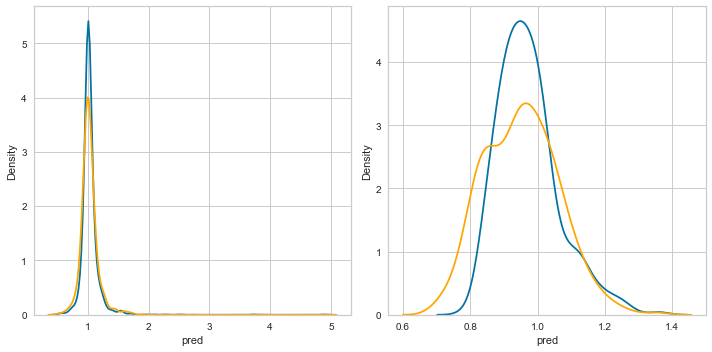

In [6109]:
import seaborn as sns
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = y_pred
y_train_pred = y_pred_train

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0])
plot = sns.kdeplot(res_df_train['test'], ax=axes[0], color='orange')
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1])
plot = sns.kdeplot(res_df_test['test'], ax=axes[1], color='orange')
fig.tight_layout()

In [6110]:
res_df_train

,pred,test,dif,dif_abs,dif%
0,0.99,0.99,0.01,0.01,0.51
1,1.01,1.00,0.01,0.01,1.06
2,1.02,1.02,0.00,0.00,0.10
3,1.07,1.07,-0.00,0.00,-0.02
4,1.04,1.06,-0.02,0.02,-2.28
...,...,...,...,...,...
2031,1.08,1.06,0.02,0.02,1.51
2032,1.09,1.08,0.01,0.01,0.89
2033,1.05,1.08,-0.03,0.03,-3.07
2034,1.02,1.07,-0.05,0.05,-4.72


In [6111]:
np.abs(res_df_test['pred']).describe()

count   324.00
mean      0.97
std       0.09
min       0.79
25%       0.91
50%       0.96
75%       1.01
max       1.36
Name: pred, dtype: float64

In [6112]:
np.abs(res_df_test['test']).describe()

count   324.00
mean      0.95
std       0.11
min       0.70
25%       0.86
50%       0.95
75%       1.03
max       1.35
Name: test, dtype: float64

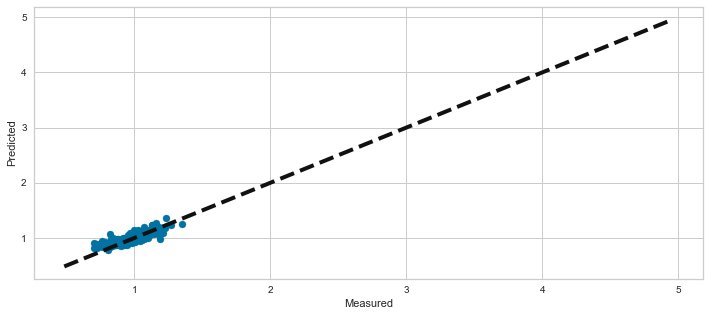

In [6113]:
fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(y_test, y_pred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

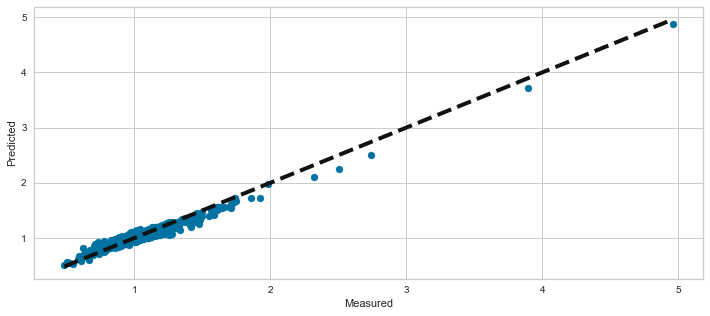

In [6114]:
fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(y_train, y_train_pred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

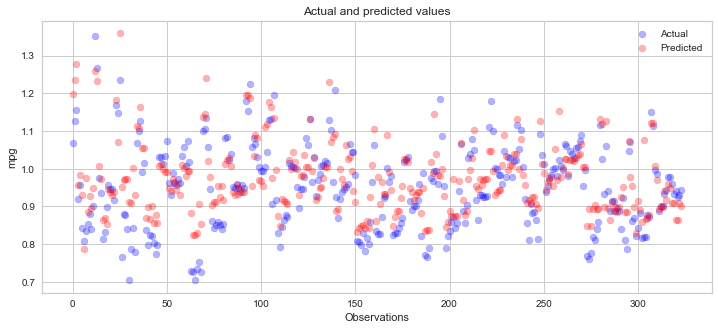

In [6115]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(12,5))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

Text(0.5, 1.0, 'R0_Predicted')

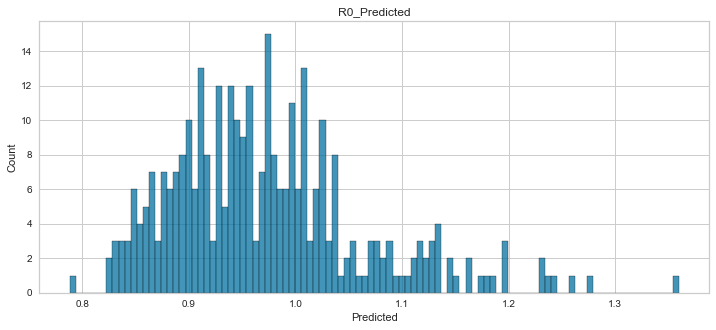

In [6116]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Predicted', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Predicted')

Text(0.5, 1.0, 'R0_Actual')

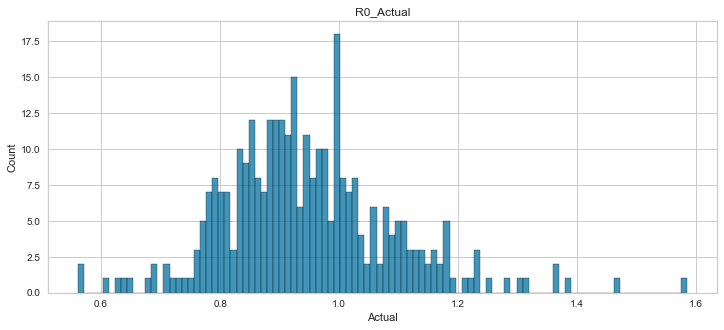

In [6117]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Actual', data=df_eval, kde=False, bins=100, ax=axes);
axes.set_title('R0_Actual')

In [6134]:
sorted_feature_importance = ctbst.feature_importances_.args()
plt.barh(df[df.columns[2:-1]].columns, 
        ctbst.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

AttributeError: 'numpy.ndarray' object has no attribute 'arg'

In [6133]:
ctbst.feature_importances_

array([ 4.48926516,  5.27841809,  4.00222298,  4.75702615,  8.25393741,
        6.47060027,  2.81453537,  2.63995468,  3.43625754,  1.35100097,
        7.28985978,  0.65453466,  1.76847343,  2.0623286 ,  3.05216922,
        1.38822505,  2.32363669,  0.82586332,  1.95789035,  4.43377682,
        0.3625154 ,  9.87679003,  4.38586771,  4.79641989,  0.        ,
       11.32843043])

In [6132]:
df[df.columns[2:-1]].columns

Index(['retail_and_recreation', 'grocery_and_pharmacy', 'residential',
       'transit_stations', 'parks', 'workplaces', 'contact_tracing',
       'testing_policy', 'international_travel_controls',
       'restrictions_internal_movements', 'close_public_transport',
       'public_information_campaigns', 'facial_coverings',
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'debt_relief', 'income_support', 'Holiday', 'temp', 'prcp',
       'urban_population', 'total_vaccinations_per_100', 'accumulated'],
      dtype='object')

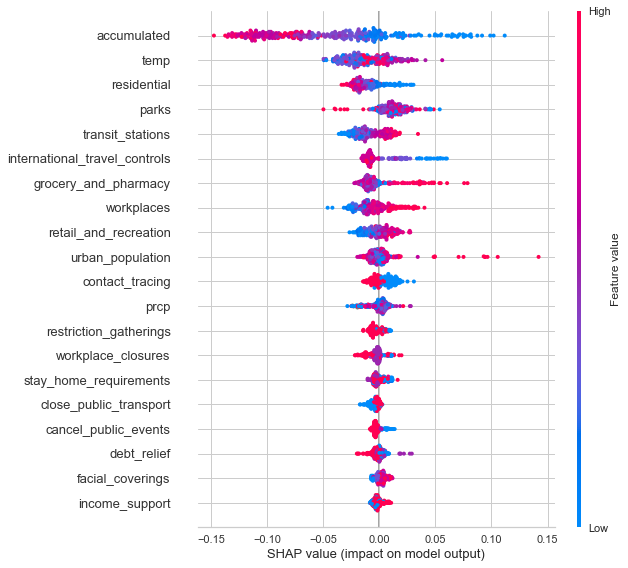

In [6125]:
import shap
explainer = shap.TreeExplainer(ctbst)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = df[df.columns[2:-1]].columns)

In [6130]:
shap_values.size

8424